In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 734M/736M [00:32<00:00, 25.7MB/s]
100% 736M/736M [00:32<00:00, 23.9MB/s]


In [ ]:
!unzip eye-diseases-classification.zip

Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_l

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D ,GlobalAveragePooling2D ,Flatten , Dense , Dropout , BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
tf.keras.applications.VGG16
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
data = []
result = []
def load_images(path):
    l1 = os.listdir(path)
#     print(l1)
    for i in l1:
        l2 = os.listdir(path+'/'+i)
        for j in l2:
            img = Image.open(path+i+'/'+j)
            img = img.resize(size=(256,256))
            data.append(np.array(img))
            result.append(i)
    %matplotlib inline
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(5, 4, i+1)
        plt.imshow(data[i], cmap="gray")
        plt.axis('off')
    plt.show()
    return np.array(data),result

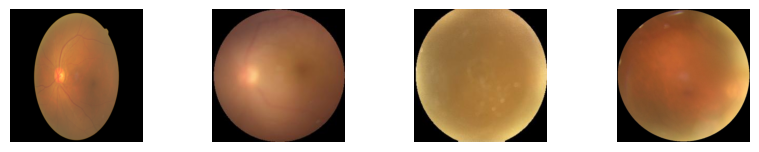

In [ ]:
data,result = load_images("/content/dataset/")

In [ ]:
data

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
t = pd.Series(result,dtype='category').cat.codes

In [ ]:
t

,0
0,0
1,0
2,0
3,0
4,0
...,...
4212,3
4213,3
4214,3
4215,3


In [ ]:
data_dir = '/content/dataset'

def preprocess_image(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.resize(image, (224, 224))
    image = cv.GaussianBlur(image, (5, 5), 0)
    image = cv.equalizeHist(image)
    image = image / 255.0
    return image



In [ ]:
def load_and_preprocess_images(data_dir, img_size=(512, 512), batch_size=100):
    images = []
    labels = []
    categories = os.listdir(data_dir)
    total_images = 0
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))]
            total_images += len(files)

    processed_images = 0
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for i, file in enumerate(os.listdir(category_path)):
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(category_path, file)
                    image = cv.imread(image_path)
                    image = cv.resize(image, img_size)
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(category)

                    processed_images += 1
                    if processed_images % batch_size == 0:
                        print(f"Processed {processed_images}/{total_images} images...")

                    # Yielding after every batch
                    if processed_images % batch_size == 0:
                        yield np.array(images), np.array(labels)
                        images, labels = [], []

    # Yield remaining images
    if images:
        yield np.array(images), np.array(labels)

In [ ]:
# Example usage:
for images_batch, labels_batch in load_and_preprocess_images(data_dir):
    # Process the batch here
    print(f"Batch size: {len(images_batch)}")


Processed 100/3119 images...
Batch size: 100
Processed 200/3119 images...
Batch size: 100
Processed 300/3119 images...
Batch size: 100
Processed 400/3119 images...
Batch size: 100
Processed 500/3119 images...
Batch size: 100
Processed 600/3119 images...
Batch size: 100
Processed 700/3119 images...
Batch size: 100
Processed 800/3119 images...
Batch size: 100
Processed 900/3119 images...
Batch size: 100
Processed 1000/3119 images...
Batch size: 100
Processed 1100/3119 images...
Batch size: 100
Processed 1200/3119 images...
Batch size: 100
Processed 1300/3119 images...
Batch size: 100
Processed 1400/3119 images...
Batch size: 100
Processed 1500/3119 images...
Batch size: 100
Processed 1600/3119 images...
Batch size: 100
Processed 1700/3119 images...
Batch size: 100
Processed 1800/3119 images...
Batch size: 100
Processed 1900/3119 images...
Batch size: 100
Processed 2000/3119 images...
Batch size: 100
Processed 2100/3119 images...
Batch size: 100
Processed 2200/3119 images...
Batch size: 1

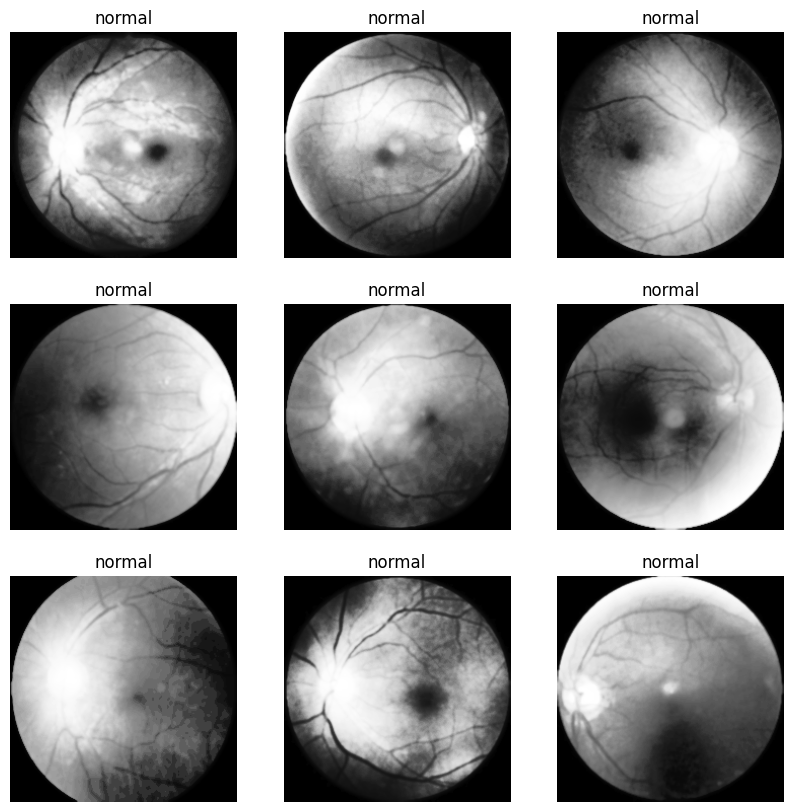

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(min(9, len(images_batch))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i], cmap='gray')
    plt.title(labels_batch[i])
    plt.axis('off')
plt.show()

In [ ]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

Saving 129_left.jpeg to 129_left.jpeg


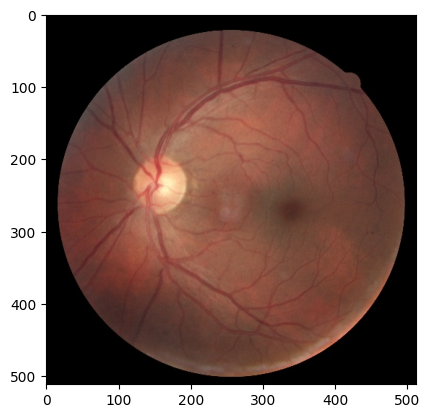

In [ ]:
uploaded = files.upload()
image_path = next(iter(uploaded))
image = plt.imread(image_path)
image.shape
plt.imshow(image)

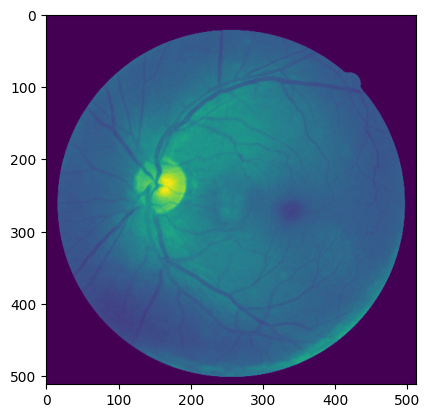

In [ ]:
gray = rgb2gray(image)
plt.imshow(gray)

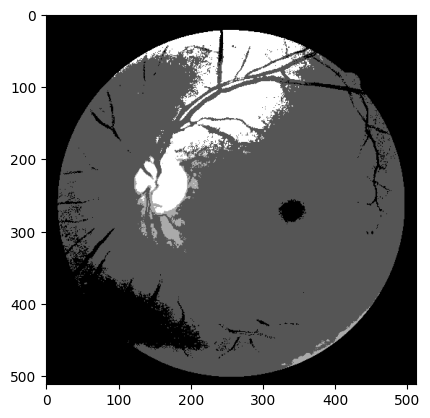

In [ ]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [ ]:
gray.shape

(512, 512)

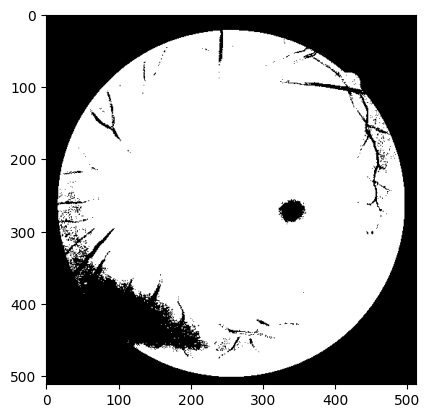

In [ ]:
gray = Image.fromarray(gray).resize((512, 512), Image.NEAREST)
gray = np.array(gray)

# Reshape the grayscale image to a 1D array
gray_r = gray.reshape(gray.shape[0] * gray.shape[1])

# Apply thresholding
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0

# Reshape back to the original dimensions
gray = gray_r.reshape(512, 512)

# Display the thresholded image
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(data ,t , test_size = 0.10 , shuffle = True , random_state = 10)

In [ ]:
print(f"x_train shape before reshaping: {np.array(x_train).shape}")
print(f"x_test shape before reshaping: {np.array(x_test).shape}")


x_train shape before reshaping: (3795, 256, 256, 3)
x_test shape before reshaping: (422, 256, 256, 3)


In [ ]:
x_train_resized = np.array([cv.resize(img, (224, 224)) for img in x_train])
x_test_resized = np.array([cv.resize(img, (224, 224)) for img in x_test])

In [ ]:
print(f"x_train shape after resizing: {x_train_resized.shape}")
print(f"x_test shape after resizing: {x_test_resized.shape}")

x_train shape after resizing: (3795, 224, 224, 3)
x_test shape after resizing: (422, 224, 224, 3)


In [ ]:
import tensorflow.keras as keras

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

# Define the input tensor with the correct shape
input_tensor = Input(shape=(224, 224, 3))  # VGG16 expects 224x224x3 input

# Load the VGG16 model with custom weights
modelVGG = VGG16(
    include_top=False,
    weights=None,  # Set to None as you will load custom weights
    input_tensor=input_tensor
)

# Load custom weights into the model
modelVGG.load_weights('/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)


In [ ]:
for layer in modelVGG.layers:
    layer.trainable = False

In [ ]:
num_classes = 4
for (i,layer) in enumerate(modelVGG.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    def lw(bottom_model,num_classes):
        top_model = bottom_model.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dropout(0.5, name='dropout_1')(top_model)
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(4, activation='softmax')(top_model)
        return top_model

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
num_classes = 4
FC_Head = lw(modelVGG , num_classes)
model = Model(inputs = modelVGG.input, outputs = FC_Head)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       2,101,2

 Total params: 33,613,636 (128.23 MB)

 Trainable params: 18,898,948 (72.09 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train_resized, y_train, epochs=10, validation_data=(x_test_resized, y_test), verbose=1)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.6711 - loss: 1.0434 - val_accuracy: 0.8341 - val_loss: 0.4371
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.8263 - loss: 0.4596 - val_accuracy: 0.8270 - val_loss: 0.4912
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8562 - loss: 0.3880 - val_accuracy: 0.8791 - val_loss: 0.3540
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8941 - loss: 0.2840 - val_accuracy: 0.8720 - val_loss: 0.3417
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.8982 - loss: 0.2462 - val_accuracy: 0.8697 - val_loss: 0.3580
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.9077 - loss: 0.2428 - val_accuracy: 0.8863 - val_loss: 0.3143
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9282 - loss: 0.1928 - val_accuracy: 0.8886 - val_loss: 0.3351
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.9185 - loss: 0

In [ ]:
loss,aac = model.evaluate(x_train_resized, y_train)

119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9551 - loss: 0.1084


In [ ]:
loss,aac = model.evaluate(x_test_resized, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9040 - loss: 0.3426


In [ ]:
def names(number):
    if number==0:
        return "Cataract"
    elif number==1:
        return "Diabetic Retinopathy"
    elif number==2:
        return "Glaucoma"
    elif number==3:
        return "Normal"

In [ ]:
from matplotlib.pyplot import imshow
def Prediction(img):
    x = np.array(img.resize((224,224)))
    x = x.reshape(1,224,224,3)
    res = model.predict_on_batch(x)
    classification = np.argmax(res)
    imshow(img)
    print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

100.0% Confidence Diabetic Retinopathy


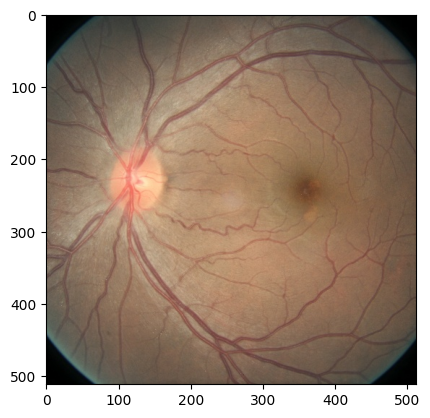

In [ ]:
img = Image.open(r"/content/dataset/diabetic_retinopathy/10009_right.jpeg")
Prediction(img)

98.86882901191711% Confidence Cataract


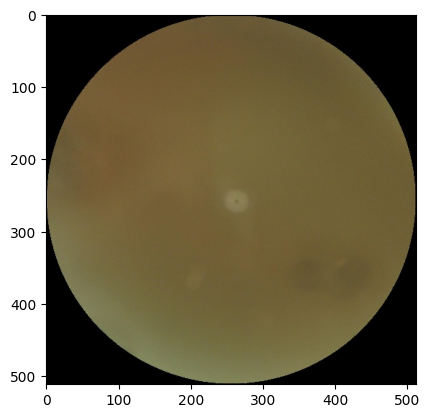

In [ ]:
img = Image.open(r"/content/dataset/cataract/0_left.jpg")
Prediction(img)

In [ ]:
model.save('model.h5')